# Importar Librerìas

In [ ]:
import joblib  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/monografia_UDEA/Salidas

## **Carga de archivo fuentes**

Se realiza el proceso de carga de los archivos correspondiente a cada moneda de análisis

In [ ]:
bitcoinOpen = pd.read_csv("dataframe_bitcoin_preprocesado.csv")

# **Modelo De Red Neuronal LSTM**

In [ ]:
#función encargada de calcular los valores de entrenamiento y testing apartir de un valor de look_Back
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# split into train and test sets
train_size = int(len(bitcoinOpen) * 0.65)
test_size = len(bitcoinOpen) - train_size
train, test = bitcoinOpen[0:train_size], bitcoinOpen[train_size:len(bitcoinOpen)]
print(len(train), len(test))

1944 1047


Se aplica el valor de look_back a los datos de entrenamiento y testing

In [ ]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX

array([[0.09868489, 0.10873508, 0.10356265, ..., 0.0642376 , 0.05255662,
        0.07312304],
       [0.10873508, 0.10356265, 0.0775664 , ..., 0.05255662, 0.07312304,
        0.07706248],
       [0.10356265, 0.0775664 , 0.0642376 , ..., 0.07312304, 0.07706248,
        0.07227794],
       ...,
       [0.66148477, 0.65993465, 0.66163762, ..., 0.66821268, 0.66459199,
        0.66635748],
       [0.65993465, 0.66163762, 0.6627191 , ..., 0.66459199, 0.66635748,
        0.66179659],
       [0.66163762, 0.6627191 , 0.66821268, ..., 0.66635748, 0.66179659,
        0.66603605]])

In [ ]:
trainY

array([0.07706248, 0.07227794, 0.06878112, ..., 0.66179659, 0.66603605,
       0.66341982])

Se hace un reshape de los datos, para ajustarlos de tal manera que la red neuronal los puede manejar

In [ ]:
# Hagamos un reshape de la forma [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Se crea el modelo de la red Neuronal y se entrena el modelo con 10 épocas que es el número de épocas que se evidenció de manera experimental que funcionaría para este caso

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1936/1936 - 9s - loss: 0.0026 - 9s/epoch - 5ms/step
Epoch 2/10
1936/1936 - 4s - loss: 1.1323e-04 - 4s/epoch - 2ms/step
Epoch 3/10
1936/1936 - 4s - loss: 1.1034e-04 - 4s/epoch - 2ms/step
Epoch 4/10
1936/1936 - 4s - loss: 1.2632e-04 - 4s/epoch - 2ms/step
Epoch 5/10
1936/1936 - 4s - loss: 1.0842e-04 - 4s/epoch - 2ms/step
Epoch 6/10
1936/1936 - 4s - loss: 1.0116e-04 - 4s/epoch - 2ms/step
Epoch 7/10
1936/1936 - 4s - loss: 1.0282e-04 - 4s/epoch - 2ms/step
Epoch 8/10
1936/1936 - 4s - loss: 9.8127e-05 - 4s/epoch - 2ms/step
Epoch 9/10
1936/1936 - 4s - loss: 9.5250e-05 - 4s/epoch - 2ms/step
Epoch 10/10
1936/1936 - 4s - loss: 8.7660e-05 - 4s/epoch - 2ms/step


**Se grafica la curva de entrenamiento**

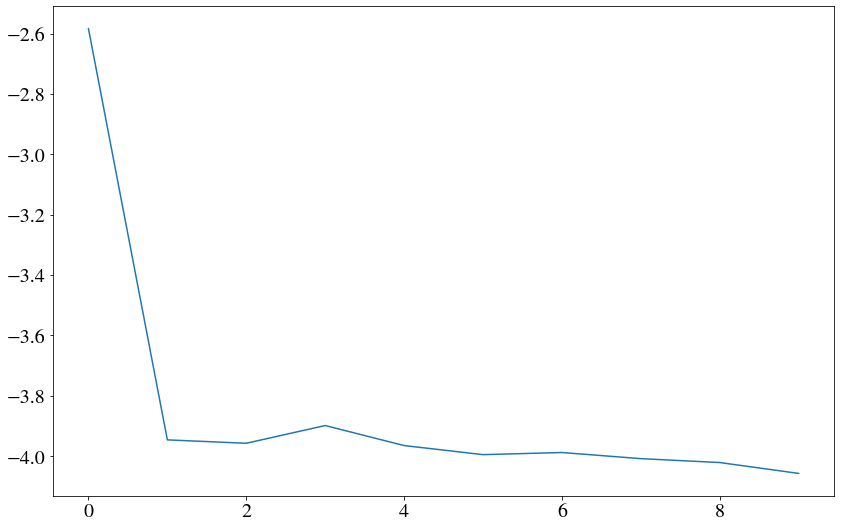

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), np.log10(loss_per_epoch))

**Se valida el modelo con los datos de entrenamiento y testing**

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1,1), trainPredict.reshape(-1,1)))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(-1,1), testPredict.reshape(-1,1)))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.02 RMSE


**Grafica de los datos de entrenamiento/predict**

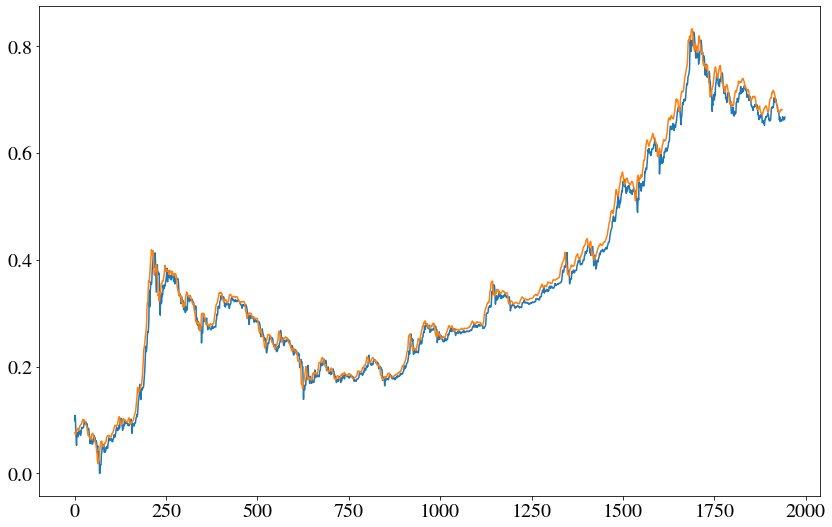

In [ ]:
plt.plot(train)
plt.plot(trainPredict)
plt.show()

**Grafica de los datos de testing/Predict**

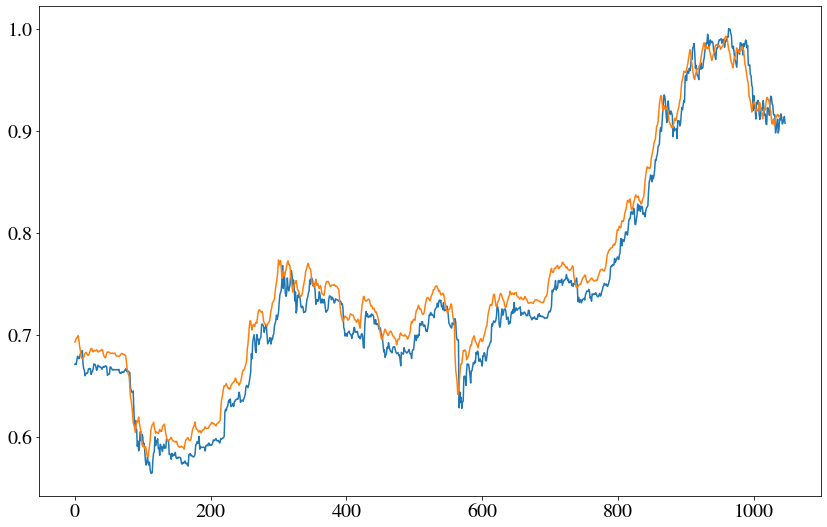

In [ ]:
plt.plot(test)
plt.plot(testPredict)
plt.show()

Luego de realizar la red neuronal, evidenciamos que el comportamiento que tiene es mucho más ajustado a la tendencia que obtuvimos por medio del modelo de AutoArima, lo que lo convierte en una solución más potente. Adicionalmente se evidencia que para los datos de entreanamiento se ve una curva muy señida con respecto a la de predicción lo que indica un Overtifiting del modelo en ese caso, pero que da un muy buen resultado cual se evalua el modelo con relación a los datos de test.

## Guardar Modelo entrenado

In [ ]:
joblib.dump(model, 'modelo_bitcoin.pkl') # Guardo el modelo.